In [1]:
import os
import random
from functools import reduce
from typing import List
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from Model.ModelEarly2D import ModelEarly2D
import time
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

read config params

In [2]:
f = open("config.txt")
configParams = f.readlines()
f.close()
configParams = eval("\n".join(configParams))

multiplierCoord = configParams["multiplierCoord"]
thresholdCuDi = configParams["thresholdCuDi"]# value in pixel
dimensionsImage,canal = np.array(configParams["dimensionsOutputImage"]),1 # x and

In [3]:
nbClass=21
pathModelGeneral,separator = "C:\\workspace2\\Datasets\\2D\\ILGDB\\Log\\glaceful-oath-10883\\","\\"
pathModel = pathModelGeneral+"Weights\\model"
pathPreprocessedData = "C:\\workspace2\\Datasets\\2D\\ILGDB\\PreprocessedData\\"
actionFileName = "Actions.csv"

dilatationRates = [1, 2, 4, 8, 16, 1, 2, 4, 8, 16]
config = {    "multiplierCoord":multiplierCoord,
              "treshCudi":thresholdCuDi,
                "dimension":[dimensionsImage[0],dimensionsImage[1]],
               "batchSize": 85,
               "lambdahyper": 32,
                "couverture":0.3,
              "weightLoss1":0.6,
              "learning_rate":0.003,
               "doGlu":False,
               "dropoutVal":0.1,
               "denseSize":300,
               "denseDropout":0.3,
               "nbFeatureMap":10,
               "dilatationRates":dilatationRates,
               "maxPoolSpatial":True,
               "poolSize":(1,3,3),
                "nbDenseLayer":1
               }

### Prepare the test data

In [4]:
trainFiles = os.listdir(pathPreprocessedData+"Train")
nbTest = len(trainFiles)
random.seed(1)
random.shuffle(trainFiles)
trainPart=0.8
nbTrain = int(trainPart*len(trainFiles))
nbValid = len(trainFiles)-nbTrain
validFiles = trainFiles[nbTrain:]
testFiles = validFiles # exp on valid
def generatorData(pathPrepro:str, filesList: List[str]):
    for file in filesList:
        data = np.load(pathPrepro + separator + file)
        # data = tf.cast(data,tf.float32)
        label = [int(file.split("_")[1].split(".")[0])]*len(data) # we repeat the label
        yield data, tf.expand_dims(label,axis=-1)
generatorDataTest = lambda  : generatorData(pathPrepro=pathPreprocessedData+"Train",filesList=validFiles)

def repeatGT(input1, input2):
    #input 2 : [batch seq 1]
    # input2 = tf.reshape(input2,[tf.shape(input2)[0],tf.shape(input2)[1]])
    # input2 = tf.one_hot(tf.cast(input2,tf.int32),nbClass) #[batch,segments,nbClass]
    return input1,(input2,input2)
def getDataset(generator):
    output_shapes = (tf.TensorShape([None, dimensionsImage[0], dimensionsImage[1], canal]),
                                       tf.TensorShape([None, 1]))
    dataset = tf.data.Dataset.from_generator(
                        generator,
                        output_types=(tf.float32, tf.float32),
                        output_shapes=output_shapes
                    )
    toPad = ((tf.constant(0.)), tf.constant(0.))
    dataset = dataset.padded_batch(1, padded_shapes=output_shapes,
                                           padding_values=toPad)

    dataset = dataset.map(repeatGT) # repeat the GT
    return dataset
datasetTest = getDataset(generatorDataTest)

In [5]:
catCroEnt = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

def lossFGWithReject(y_true,y_pred,lambdaHyper):
    #y_true: [batch,nbSeg,nbClass]
    #y_pred: [batch,nbSeg,nbClass]
    loss = catCroEnt(
        tf.repeat(y_pred[:,:,:1],nbClass,axis=2) * y_true, # g(x)*ytrue * log(pred)
        y_pred[:,:,1:])
    loss += lambdaHyper*tf.maximum(config["couverture"]-tf.reduce_mean(y_pred[:,:,0]),0)**2
    return loss

def lossHAux(y_true,y_pred):
    loss = catCroEnt(y_true,y_pred)
    return loss
model = ModelEarly2D(nbClass=nbClass,boxSize=(dimensionsImage[0],dimensionsImage[1],canal),
                     doGLU=config["doGlu"],dropoutVal=config["dropoutVal"],denseNeurones=config["denseSize"],
                     denseDropout=config["denseDropout"],nbFeatureMap=config["nbFeatureMap"],
                     dilatationsRates=config["dilatationRates"],maxPoolSpatial=config["maxPoolSpatial"],
                     poolSize=config["poolSize"],poolStrides=config["poolSize"])
opti = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
model.compile(opti, loss=[lambda x,y:lossFGWithReject(x,y,config['lambdahyper']),lossHAux], metrics=[])
model.load_weights(pathModel)

In [6]:
# model.evaluate(datasetTest)

In [7]:
eval = model.predict(datasetTest,steps=1)
print(eval[0].shape)

(1, 12, 22)


In [8]:
iterator = iter(datasetTest)

In [9]:
N = [0]*nbClass
TrueAccept = [0]*nbClass
TrueAcceptAt = []
FalseAcceptAt = []
FalseAccept = [0]*nbClass
averageLengthCompletion = [[] for i in range(nbClass)]

rejected = [0]*nbClass
# FalseReject = 0
# TrueReject = 0
# ScoreByLength = {}

In [10]:
%%time

for i,data in enumerate(iterator):
    if(i%100==0):
        print(i,"/",len(testFiles))
    # file = testFiles[i]
    # print(file)
    input = data[0]
    GT = data[1][0][0][0][0].numpy() # the GT is repeted along this axis
    N[int(GT)]+=1

    prediction = model(input,steps=1)[0][0] # get prediction output
    # print("prediction",tf.shape(prediction))
    rejection = prediction[:,0]
    rejection = tf.greater(rejection,0.5).numpy()
    prediction = prediction[:,1:]
    prediction = tf.argmax(prediction,axis=1).numpy()
    acceptIndex = np.where(rejection>0.5)[0]
    if len(acceptIndex)>0:
        firstAcceptIndex = acceptIndex[0]
        pred = prediction[firstAcceptIndex]
        if firstAcceptIndex==len(prediction)-1:
            firstAcceptIndex -= 1 # if we predict on the black image, it's 100% of gestures completion, like the last true image
        if pred==GT:
            TrueAccept[int(GT)]+=1
            TrueAcceptAt+=[float(firstAcceptIndex+1)/(float(len(prediction)-1))] # -1 because black img didnt count
        else:
            FalseAccept[int(GT)]+=1
            FalseAcceptAt+=[float(firstAcceptIndex+1)/(float(len(prediction)-1))]
        averageLengthCompletion[int(GT)]+=[float(firstAcceptIndex+1)/(float(len(prediction)-1))]
    else:
        rejected[int(GT)] +=1

0 / 693
100 / 693
200 / 693
300 / 693
400 / 693
500 / 693
600 / 693
Wall time: 20.8 s


In [11]:
N = np.array(N)
TrueAccept = np.array(TrueAccept)
FalseAccept = np.array(FalseAccept)
rejected = np.array(rejected)
avPerClass = [sum(av)/len(av) if len(av)>0 else 1 for av in averageLengthCompletion]

res = ""
res+="TrueAcceptPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in TrueAccept/N])))+"\n"
res+="FalseAcceptPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in  FalseAccept/N])))+"\n"
res+="rejectedPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in rejected/N])))+"\n"
res+="averageLengthCompletionPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in avPerClass])))+"\n"
N_ = sum(np.array(N))
TrueAccept_ = sum(np.array(TrueAccept))
FalseAccept_ = sum(np.array(FalseAccept))
rejected_ = sum(np.array(rejected))
res+="TrueAccept,\n"+str(TrueAccept_/N_)+"\n"
res+="FalseAccept,\n"+str(FalseAccept_/N_)+"\n"
res+="rejected,\n"+str(rejected_/N_)+"\n"
allAv = reduce(lambda a,b:a+b,averageLengthCompletion)
avScalar = sum(allAv)/len(allAv)
res+="averageLengthCompletion\n"+str(avScalar)+"\n"


print(res)

TrueAcceptPerClass,
1.00 ; 1.00 ; 1.00 ; 1.00 ; 0.98 ; 1.00 ; 0.96 ; 1.00 ; 0.97 ; 0.61 ; 1.00 ; 0.97 ; 0.94 ; 0.91 ; 0.91 ; 0.67 ; 1.00 ; 1.00 ; 0.97 ; 0.90 ; 0.97
FalseAcceptPerClass,
0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.02 ; 0.00 ; 0.04 ; 0.00 ; 0.03 ; 0.00 ; 0.00 ; 0.03 ; 0.00 ; 0.06 ; 0.09 ; 0.03 ; 0.00 ; 0.00 ; 0.00 ; 0.10 ; 0.03
rejectedPerClass,
0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.39 ; 0.00 ; 0.00 ; 0.06 ; 0.03 ; 0.00 ; 0.30 ; 0.00 ; 0.00 ; 0.03 ; 0.00 ; 0.00
averageLengthCompletionPerClass,
0.99 ; 0.68 ; 0.67 ; 0.77 ; 0.95 ; 0.71 ; 0.88 ; 0.64 ; 0.67 ; 0.82 ; 0.79 ; 0.76 ; 0.79 ; 0.82 ; 0.57 ; 1.00 ; 0.77 ; 0.68 ; 0.83 ; 0.80 ; 0.74
TrueAccept,
0.9451659451659452
FalseAccept,
0.020202020202020204
rejected,
0.03463203463203463
averageLengthCompletion
0.7749838504943458



In [12]:
# f = open(pathModelGeneral+"resultsEval.txt","w+")
# f.write(res)
# f.close()

## Exploring per class scores

In [13]:
f = open(pathPreprocessedData+actionFileName)
actions  =  f.readlines()
f.close()
actions = list(map(lambda s: s.split(";")[1].strip(),actions))


Text(0, 0.5, 'Earliness')

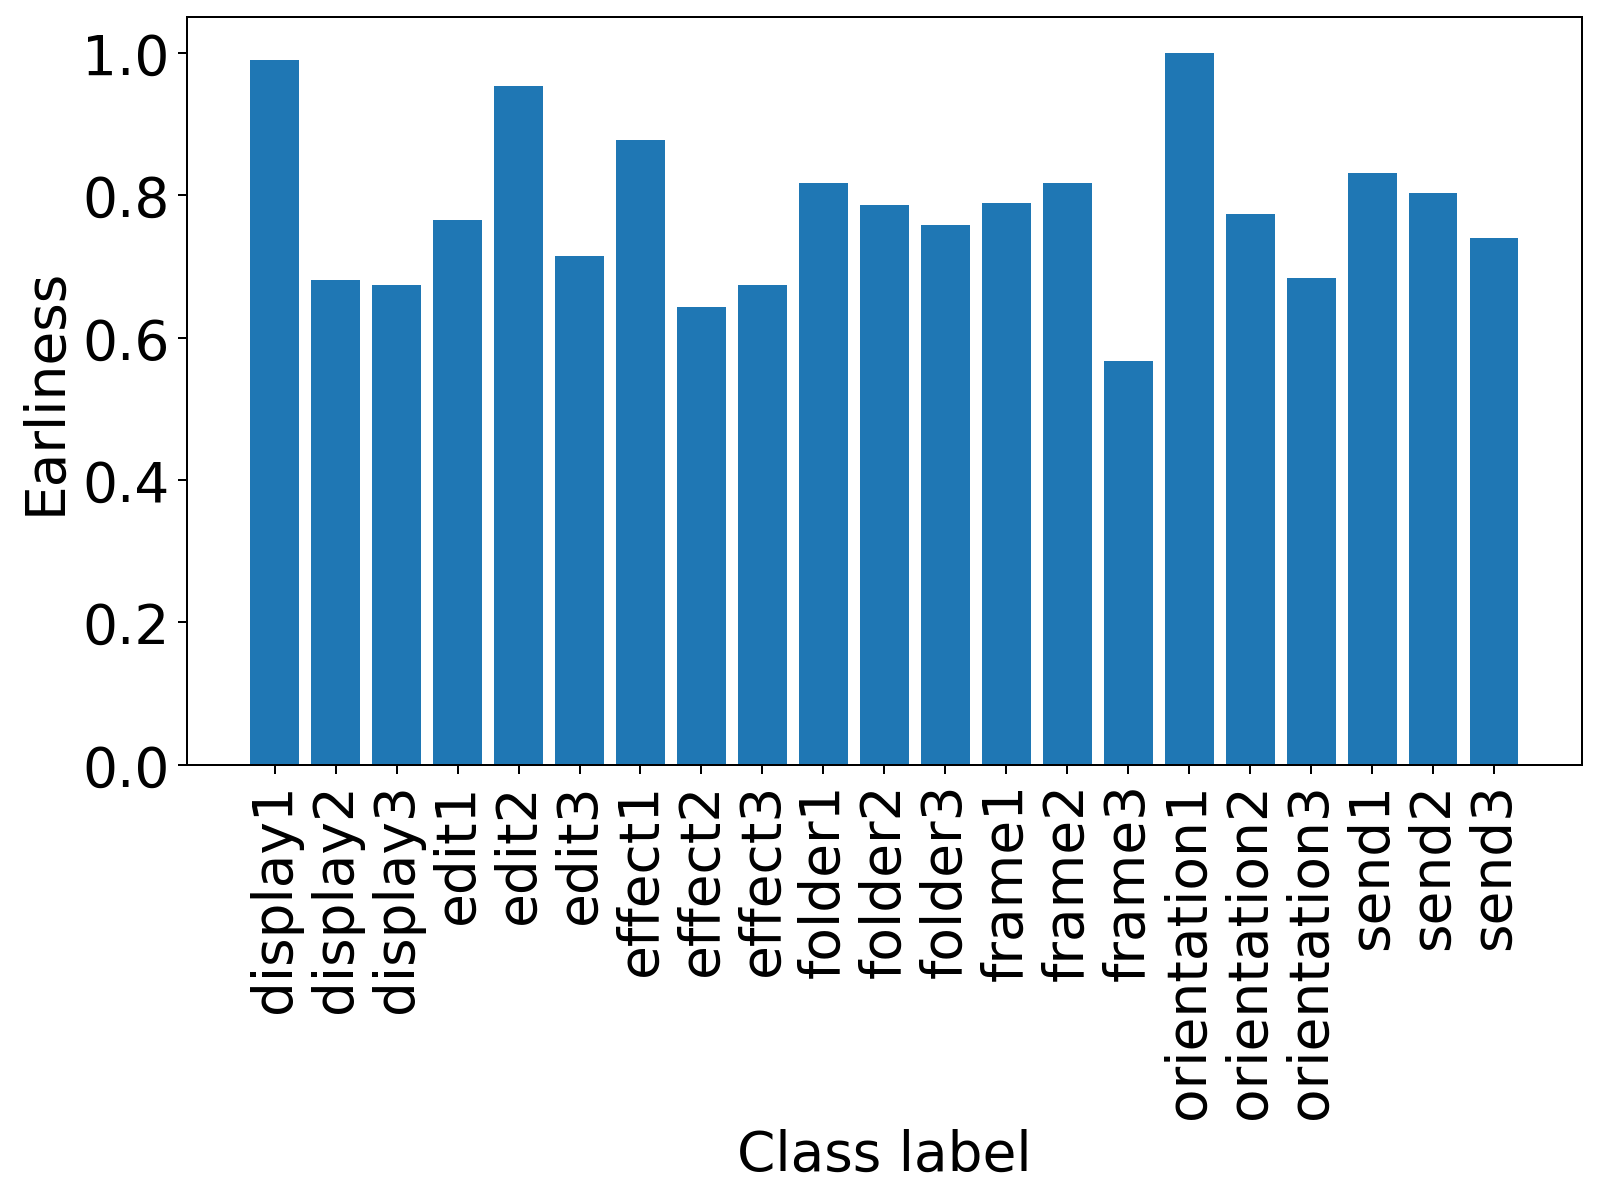

In [14]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5.5),dpi=180)
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 18})
_ = plt.bar(actions, avPerClass)


plt.xlabel('Class label')
plt.ylabel('Earliness')
# plt.title('Histogram representing the earliness of each class')

# plt.savefig(pathModelGeneral+"earlinessPerClass.eps", bbox_inches='tight',format='eps')
# plt.savefig(pathModelGeneral+"earlinessPerClass", bbox_inches='tight')

In [15]:
len(averageLengthCompletion)

21

## Behaviour with reject

Text(0, 0.5, 'Rate')

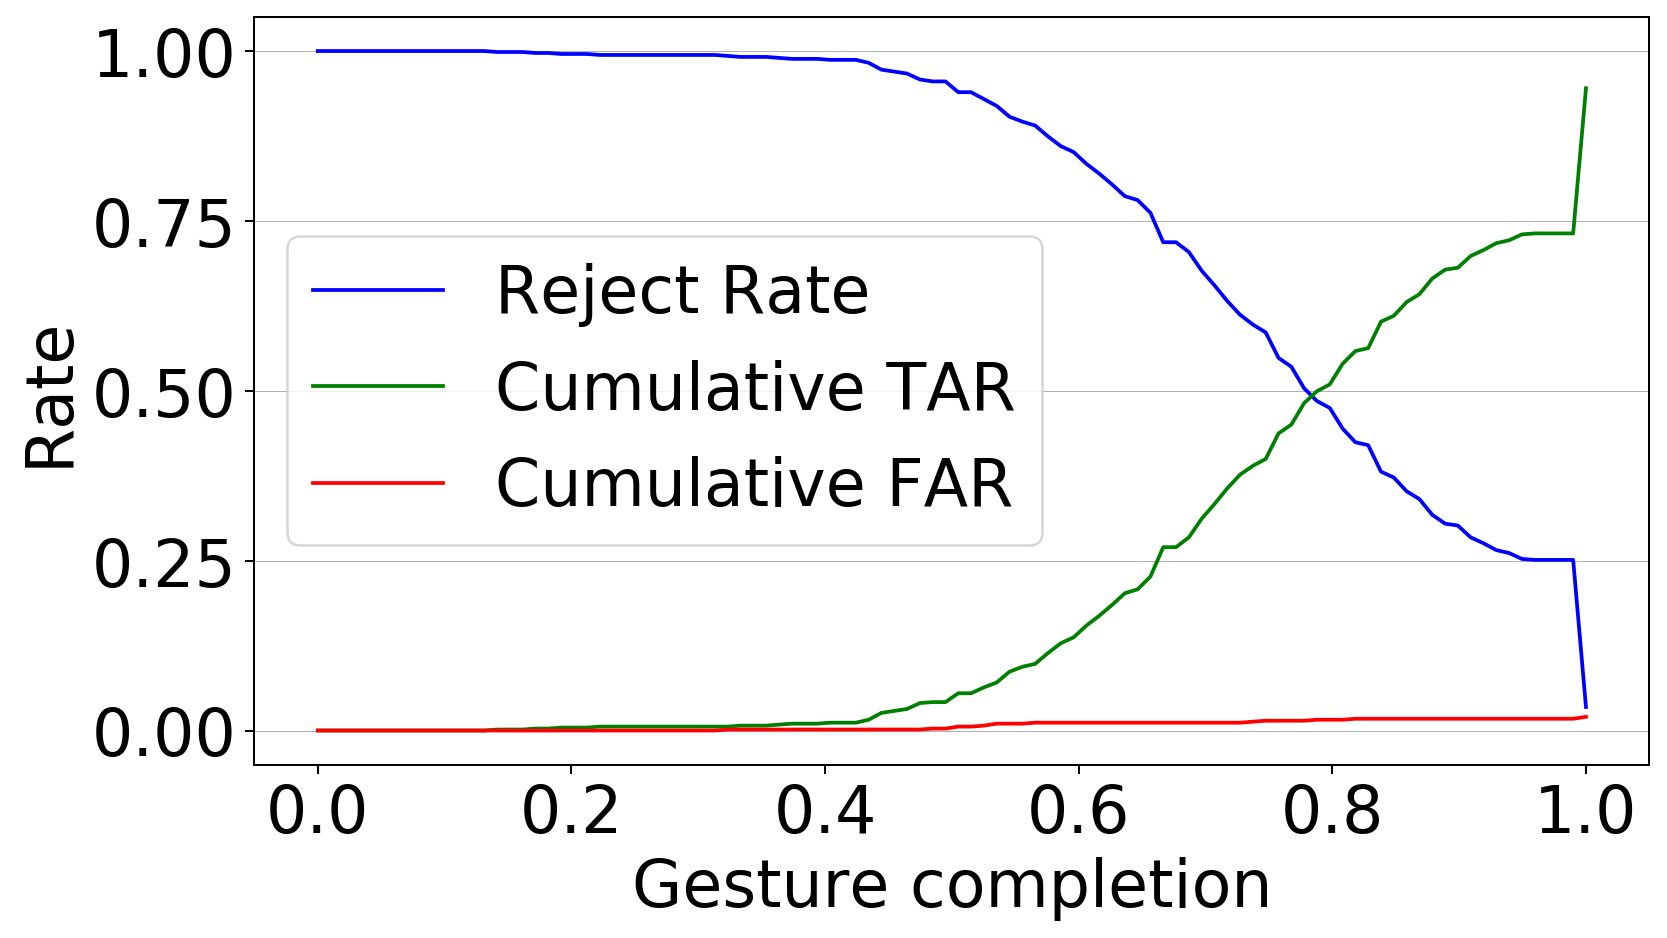

In [16]:
plt.figure(figsize=(10,5.5),dpi=180)
plt.rcParams.update({'font.size': 26})
xAbs = np.linspace(0,1,100)
flat_averageLengthCompletion = [item for sublist in averageLengthCompletion for item in sublist]

lengcomplt = np.array(flat_averageLengthCompletion)
# lengcomplt[]
rejectsAt = np.array(list(map(lambda x : 1-len(lengcomplt[lengcomplt<=x])/N_,xAbs)))
plt.plot(xAbs, rejectsAt,color="blue")


TrueAcceptAt = np.array(TrueAcceptAt)
FalseAcceptAt = np.array(FalseAcceptAt)
totalExemples = len(lengcomplt)

#cumulated TAR and FAR
TARAt = np.array(list(map(lambda x : len(TrueAcceptAt[TrueAcceptAt<=x])/N_,xAbs)))
plt.plot(xAbs, TARAt,color="green")



FARAt = np.array(list(map(lambda x : len(FalseAcceptAt[FalseAcceptAt<=x])/N_,xAbs)))
plt.plot(xAbs, FARAt,color="red")
plt.grid(axis="y",linestyle="-",linewidth=.4)

plt.legend(["Reject Rate","Cumulative TAR","Cumulative FAR"])
plt.xlabel("Gesture completion")
plt.ylabel("Rate")


# plt.savefig(pathModelGeneral+"TAR_FAR_Reject.eps", bbox_inches='tight',format='eps')
# plt.savefig(pathModelGeneral+"TAR_FAR_Reject", bbox_inches='tight')